In [1]:
import pandas as pd

data = pd.read_excel("ground_truth.xlsx")
data.head()

,qid,query,type,method,rank,source_id,text,label
0,1,Carikan Buku Natural Language Processing,catalog,bm25,1,cat_55856,Judul: Introduction to Natural Language Proces...,1
1,1,Carikan Buku Natural Language Processing,catalog,bm25,2,cat_58107_s1,Judul: Neural network methods for natural lang...,1
2,1,Carikan Buku Natural Language Processing,catalog,bm25,3,cat_51633,Judul: Foundations of Statistical Natural Lang...,1
3,1,Carikan Buku Natural Language Processing,catalog,bm25,4,cat_58113,Judul: Deep learning for natural language proc...,1
4,1,Carikan Buku Natural Language Processing,catalog,faiss,1,cat_55856_s1,Judul: Introduction to Natural Language Proces...,1


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   qid        1332 non-null   int64 
 1   query      1332 non-null   object
 2   type       1332 non-null   object
 3   method     1332 non-null   object
 4   rank       1332 non-null   int64 
 5   source_id  1332 non-null   object
 6   text       1332 non-null   object
 7   label      1332 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 83.4+ KB


In [3]:
def precision_recall_at_k(data, k=4):
    rows = []

    for (qid, method), g in data.groupby(["qid", "method"]):
        g = g.sort_values("rank").head(k)

        retrieved = len(g)
        relevant_retrieved = g["label"].sum()

        total_relevant = data[(data["qid"] == qid) & (data["label"] == 1)]["source_id"].nunique()

        precision = relevant_retrieved / retrieved if retrieved else 0
        recall = relevant_retrieved / total_relevant if total_relevant else 0

        rows.append({
            "qid": qid,
            "method": method,
            "precision@k": precision,
            "recall@k": recall
        })
    return pd.DataFrame(rows)

In [4]:
metrics = precision_recall_at_k(data, k=4)
metrics.head(30)

,qid,method,precision@k,recall@k
0,1,bm25,1.00,0.571429
1,1,faiss,1.00,0.571429
2,1,hybrid,1.00,0.571429
3,2,bm25,0.25,1.000000
4,2,faiss,0.00,0.000000
5,2,hybrid,0.25,1.000000
6,3,bm25,0.75,1.000000
7,3,faiss,0.00,0.000000
8,3,hybrid,0.50,0.666667
9,4,bm25,0.25,1.000000


In [5]:
metrics["f1@k"] = (2 * metrics["precision@k"] * metrics["recall@k"]/ (metrics["precision@k"] + metrics["recall@k"])).fillna(0)
metrics.head()

,qid,method,precision@k,recall@k,f1@k
0,1,bm25,1.00,0.571429,0.727273
1,1,faiss,1.00,0.571429,0.727273
2,1,hybrid,1.00,0.571429,0.727273
3,2,bm25,0.25,1.000000,0.400000
4,2,faiss,0.00,0.000000,0.000000


In [6]:
summary = (metrics.groupby("method")[["precision@k", "recall@k", "f1@k"]].mean().reset_index())
summary

,method,precision@k,recall@k,f1@k
0,bm25,0.389640,0.754522,0.453152
1,faiss,0.333333,0.609788,0.376325
2,hybrid,0.409910,0.810239,0.480422


In [7]:
pivot = metrics.pivot(index="qid", columns="method", values="recall@k")

pivot["hybrid_minus_bm25"] = pivot["hybrid"] - pivot["bm25"]
pivot.sort_values("hybrid_minus_bm25", ascending=False).head(10)

method,bm25,faiss,hybrid,hybrid_minus_bm25
qid,,,,
37,0.000000,1.000000,1.0,1.000000
40,0.000000,1.000000,1.0,1.000000
33,0.000000,1.000000,1.0,1.000000
45,0.000000,1.000000,1.0,1.000000
47,0.000000,1.000000,1.0,1.000000
24,0.000000,0.000000,1.0,1.000000
91,0.000000,1.000000,1.0,1.000000
5,0.333333,0.666667,1.0,0.666667
96,0.500000,1.000000,1.0,0.500000


In [8]:
rank_analysis = (data[data["label"] == 1].groupby(["method", "rank"]).size().unstack(fill_value=0))
rank_analysis

rank,1,2,3,4
method,,,,
bm25,77,39,33,24
faiss,65,33,28,22
hybrid,74,47,31,30


In [9]:
pivot["hybrid_minus_bm25"] = pivot["hybrid"] - pivot["bm25"]
top_hybrid_queries = (pivot.sort_values("hybrid_minus_bm25", ascending=False).head(5).index)

data[data["qid"].isin(top_hybrid_queries) &(data["method"].isin(["bm25", "hybrid"]))][["qid", "query", "method", "rank", "label", "text"]].sort_values(["qid", "method", "rank"])

,qid,query,method,rank,label,text
384,33,Bisa carikan info denda dan jam buka perpus gak?,bm25,1,0,5. Panduan Penggunaan Layanan dan Fasilitas 5....
385,33,Bisa carikan info denda dan jam buka perpus gak?,bm25,2,0,• Ruang baca umum Pengguna dapat langsung mema...
386,33,Bisa carikan info denda dan jam buka perpus gak?,bm25,3,0,Sebagian program studi mensyaratkan buku sumba...
387,33,Bisa carikan info denda dan jam buka perpus gak?,bm25,4,0,Data Operasional Perpustakaan Universitas Kris...
392,33,Bisa carikan info denda dan jam buka perpus gak?,hybrid,1,1,makanan dan minuman ke area makan perpustakaan...
393,33,Bisa carikan info denda dan jam buka perpus gak?,hybrid,2,0,• Ruang baca umum Pengguna dapat langsung mema...
394,33,Bisa carikan info denda dan jam buka perpus gak?,hybrid,3,0,5. Panduan Penggunaan Layanan dan Fasilitas 5....
395,33,Bisa carikan info denda dan jam buka perpus gak?,hybrid,4,0,• Area lesehan yang nyaman untuk membaca santa...
432,37,Masa pinjam normal berapa lama?,bm25,1,0,"Judul: Design for flexibility : Penulis: Boy, ..."
433,37,Masa pinjam normal berapa lama?,bm25,2,0,Judul: Design of Analog CMOS Integrated Circui...


In [10]:
import matplotlib.pyplot as plt

def pr_points(data, method, max_k=4):
    points = []
    for k in range(1, max_k + 1):
        m = precision_recall_at_k(data, k)
        row = m[m["method"] == method]
        points.append((
            row["recall@k"].mean(),
            row["precision@k"].mean()
        ))
    return zip(*points)

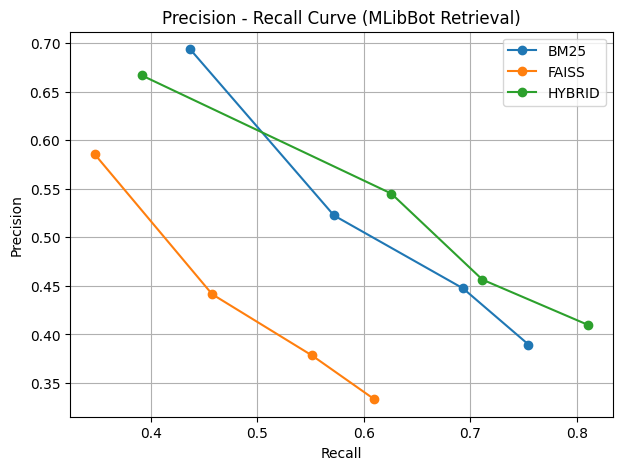

In [11]:
plt.figure(figsize=(7,5))

for method in ["bm25", "faiss", "hybrid"]:
    recall, precision = pr_points(data, method)
    plt.plot(recall, precision, marker="o", label=method.upper())

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision - Recall Curve (MLibBot Retrieval)")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
data[data["method"]=="faiss"][["query","rank","label","text"]].head(10)

,query,rank,label,text
4,Carikan Buku Natural Language Processing,1,1,Judul: Introduction to Natural Language Proces...
5,Carikan Buku Natural Language Processing,2,1,Judul: Deep learning for natural language proc...
6,Carikan Buku Natural Language Processing,3,1,Judul: Neural network methods for natural lang...
7,Carikan Buku Natural Language Processing,4,1,Judul: Foundations of Statistical Natural Lang...
16,Jam Layanan Perpustakaan,1,0,makanan dan minuman ke area makan perpustakaan...
17,Jam Layanan Perpustakaan,2,0,5. Panduan Penggunaan Layanan dan Fasilitas 5....
18,Jam Layanan Perpustakaan,3,0,• Ruang baca umum Pengguna dapat langsung mema...
19,Jam Layanan Perpustakaan,4,0,• Area lesehan yang nyaman untuk membaca santa...
28,Bisa Carikan buku yang terbit tahun 2020?,1,0,Judul: Websters New World Student Writing Hand...
29,Bisa Carikan buku yang terbit tahun 2020?,2,0,Judul: Launching the Imagination: Penulis: nan...
